## Network that classifies land uses and land covers from satellite imagery

### 1. Find the dataset


### 2. Explore the dataset

### 3. Build the model and save it using Tensorflow callback

In [ ]:
# Import necessary libraries for deep learning, image processing, and visualization
from tensorflow.keras.models import Sequential  # For creating sequential neural network models
from tensorflow.keras.layers import Dense       # For adding dense layers to the network
from tensorflow.keras.preprocessing import image  # General image preprocessing utilities
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Specific image preprocessing functions
import numpy as np          # For numerical operations on arrays
from matplotlib import pyplot as plt  # For creating visualizations
import os                   # For file system operations

# Define the path where the satellite image data is stored
IMAGE_PATH = 'data/Satellite Image Data/archive/images'

# Create a list of all land use classes in the dataset
# These 21 classes represent different types of land use patterns in satellite imagery
LAND_USE = ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 
             'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway','sparseresidential', 'storagetanks', 'tenniscourt']

# Create a dictionary that maps each land use class name to a unique numerical index
# This is necessary because the model needs numerical labels for training
LABEL_MAP = {label: num for num, label in enumerate(LAND_USE)}

# Define a utility function to convert an image file to a normalized numpy array
# Parameters:
# - path: The file path to the image
# Returns:
# - A normalized numpy array representation of the image
def conv_to_array(path):
    # Load the image and resize it to 128x128 pixels
    img = load_img(path, target_size=(128, 128))
    # Convert the PIL Image to a numpy array
    img = img_to_array(img)
    # Normalize pixel values to be between 0 and 1 (division by 255)
    # This helps with model training stability and convergence
    img = img/255.
    return img

In [ ]:
# Initialize an empty list to store the class labels
y = []

# Process all images from each land use class
# This loop iterates through all classes and their respective images
for label in LABEL_MAP:
    # For each label, process 500 images (indexed from 1 to 500)
    for land in range(500):
        # Construct the full path to the image file using string formatting
        # Format: /path/to/images/label/label_000001.png, /path/to/images/label/label_000002.png, etc.
        path = os.path.join(IMAGE_PATH, '{}/{}_000{:03d}.png'.format(label, label, land+1))
        
        # Add the numerical label to our labels list
        # This maps the current image to its corresponding class index from LABEL_MAP
        y.append(LABEL_MAP[label])
        
        # Convert the image to a normalized numpy array using our utility function
        img = conv_to_array(path)
        
        # Construct the path where we'll save the numpy array version of the image
        # Same pattern as the image path but without the .png extension
        npy_path = os.path.join(IMAGE_PATH, '{}/{}_000{:03d}'.format(label, label, land+1))
        
        # Save the processed image as a numpy file (.npy)
        # This allows for faster loading in future processing steps
        np.save(npy_path, img)
        
# Convert the list of labels to a numpy array for compatibility with Keras
# This will be a 1D array with 10,500 elements (21 classes * 500 images per class)
y = np.array(y)

# The comment indicates the next step would be to combine all individual numpy files
# into a single x array for model training

In [8]:
y.shape

(10500,)

In [ ]:
# Load image data from NumPy files organized by label categories into array x
# This creates the feature array by reading all previously saved .npy files

# Initialize an empty list to store all image data
x = []

# Iterate through each land use class in our label map
for label in LABEL_MAP:
   # For each class, process all 500 images (numbered 1-500)
   for land in range(500):
       # Construct the path to the numpy file using the same pattern used when saving
       # Format: /path/to/images/label/label_000001.npy, /path/to/images/label/label_000002.npy, etc.
       path = os.path.join(IMAGE_PATH, '{}/{}_000{:03d}.npy'.format(label, label, land+1))
       
       # Load the numpy array from the file
       # Each file contains a normalized image representation (128x128x3)
       res = np.load(path)
       
       # Append the loaded image array to our list of images
       x.append(res)

# Convert the list of image arrays into a single 4D numpy array
# Shape will be (10500, 128, 128, 3) where:
# - 10500 is the total number of images (21 classes * 500 images per class)
# - 128x128 is the image dimensions
# - 3 is the number of color channels (RGB)
x = np.array(x)

In [10]:
x.shape

(10500, 128, 128, 3)

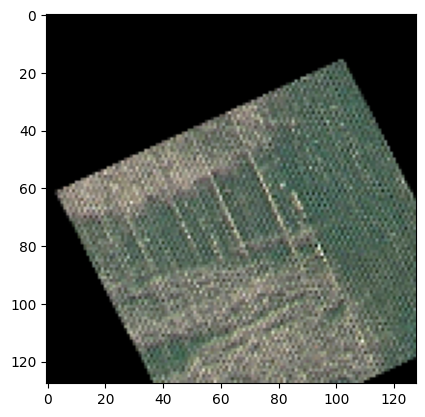

In [11]:
plt.imshow(x[0])

In [ ]:
# Train Test Split
# Divide the dataset into training and testing subsets for model evaluation

from sklearn.model_selection import train_test_split  # Import the function for splitting datasets

# Split the data into training and testing sets
# Parameters:
# - x: The feature data (all image arrays) with shape (10500, 128, 128, 3)
# - y: The target labels (class indices) with shape (10500,)
# - test_size=0.2: 20% of the data will be used for testing, 80% for training
# 
# Returns four arrays:
# - X_train: Training images (80% of data, approx. 8400 images)
# - X_test: Testing images (20% of data, approx. 2100 images)
# - y_train: Training labels corresponding to X_train
# - y_test: Testing labels corresponding to X_test
#
# The split is done randomly but in a way that preserves the class distribution
# between training and testing sets (stratified sampling)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [13]:
print("Training data size is", X_train.shape)
print("Training labels contain", y_train.shape)
print("Test data size is", X_test.shape)
print("Test labels contain", y_test.shape)

Training data size is (8400, 128, 128, 3)
Training labels contain (8400,)
Test data size is (2100, 128, 128, 3)
Test labels contain (2100,)


#### Custom model build

In [ ]:
# Import required Keras modules for building and training neural networks
from tensorflow.keras.models import Sequential  # Sequential model allows stacking layers linearly
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout  # Various layer types
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint  # Callbacks for training process
from tensorflow.keras.optimizers import Adam  # Adam optimizer for gradient descent
import tensorflow as tf  # Core TensorFlow library

# Initialize a sequential model - layers will be added one by one in sequence
model = Sequential()

# First convolutional block
# Add first convolutional layer with 32 filters, 3x3 kernel, ReLU activation, same padding, and input shape 128x128x3
model.add(Conv2D(32, kernel_size=3, input_shape=(128,128,3), activation='relu', padding='same'))
# Add second convolutional layer with 64 filters, 3x3 kernel, ReLU activation, and same padding
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
# Add max pooling layer to reduce spatial dimensions by half (2x2 pooling)
model.add(MaxPooling2D(pool_size=2))
# Add dropout layer with 30% rate to prevent overfitting
model.add(Dropout(0.3))

# Second convolutional block - commented out as it did not improve model performance
# model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))  # 64 filters, 3x3 kernel with ReLU
# model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))  # 128 filters, 3x3 kernel with ReLU
# model.add(MaxPooling2D(pool_size=2))  # Max pooling to reduce dimensions
# model.add(Dropout(0.3))  # 30% dropout for regularization

# Third convolutional block - commented out as it did not improve model performance
# model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))  # 128 filters, 3x3 kernel with ReLU
# model.add(Conv2D(256, kernel_size=3, activation='relu', padding='same'))  # 256 filters, 3x3 kernel with ReLU
# model.add(MaxPooling2D(pool_size=2))  # Max pooling to reduce dimensions
# model.add(Dropout(0.3))  # 30% dropout for regularization

# First dense layer configuration - commented out as it did not improve model performance
# model.add(Flatten())  # Flatten the 2D feature maps to 1D feature vectors
# model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)))  # Dense layer with L1 and L2 regularization
# model.add(Dropout(0.5))  # 50% dropout for stronger regularization

# Flattening layer to convert 2D feature maps to 1D feature vectors for dense layers
model.add(Flatten())
# Dense layer with 64 neurons, ReLU activation, and both L1 (1e-5) and L2 (1e-4) regularization to prevent overfitting
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)))
# Dropout layer with 50% rate for strong regularization before final classification
model.add(Dropout(0.5))
# Output layer with 21 neurons (one per class) and softmax activation for multi-class classification
model.add(Dense(21, activation='softmax'))

# Create Adam optimizer with initial learning rate of 0.01
opt = Adam(learning_rate=1e-2)

# Compile the model with sparse categorical crossentropy loss (suitable for integer labels)
# and accuracy as the evaluation metric
model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define directory paths for saving model artifacts
SAVE_DIR = os.path.join('model_savepath')  # Base directory for saving
LOG_DIR = os.path.join('logs')  # Directory for TensorBoard logs
MODEL_DIR = os.path.join('models')  # Directory for saved model checkpoints

# Create TensorBoard callback for visualizing training metrics
tf_callback = TensorBoard(LOG_DIR)
# Create early stopping callback to prevent overfitting - stops training when validation accuracy stops improving
# Will wait for 10 epochs without improvement before stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [ ]:
model.summary()

In [ ]:
# Train the model with these parameters:
# - X_train and y_train are the training data features and labels
# - Using TensorBoard callback to log training metrics for visualization
# - Using early stopping callback to prevent overfitting by monitoring validation accuracy
# - Maximum of 200 epochs (training cycles through the entire dataset)
# - Batch size of 64 samples per gradient update
# - 10% of training data reserved for validation during training
model.fit(X_train, y_train, callbacks=[tf_callback, early_stopping], epochs=200, batch_size=64, validation_split=0.10)

In [ ]:
# Define the directory path for storing model files
MODEL_DIR = os.path.join('models')
# Save the trained model to disk with filename 'sequential_33.keras'
# This allows the model to be loaded later for inference or further training
# The .keras format stores the model architecture, weights, and optimizer state
model.save(os.path.join(MODEL_DIR, 'sequential_33.keras'))

In [ ]:
del model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('models/sequential_19_35per.keras')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

### Live tracking using screen capture

In [ ]:
# Image processing using built model
# This function processes an image and returns the top 5 predicted land use classes

from tensorflow.keras.preprocessing import image  # Import image preprocessing utilities
import numpy as np  # Import numpy for array operations

def get_top_5_preds(img):
    """
    Process an image and return the top 5 predicted land use classes with confidence scores.
    
    Parameters:
    - img: Path to the image file to be classified
    
    Returns:
    - top5_name: List of the top 5 predicted class names in descending order of confidence
    - top5_percent: List of confidence percentages corresponding to the top 5 predictions
    """
    # Load the image and resize it to 128x128 pixels (the model's expected input size)
    img = load_img(img, target_size=(128,128))
    
    # Convert the PIL Image to a numpy array
    img = img_to_array(img)
    
    # Normalize pixel values to the range [0,1] as done during training
    img = img/255.
    
    # Add a batch dimension to the image (model expects batches)
    # This transforms the image shape from (128,128,3) to (1,128,128,3)
    # The expanded dimension represents a batch size of 1
    preds = model.predict(np.expand_dims(img, axis=0))
    
    # Turn off axis display for the image plot
    plt.axis('off')
    
    # Display the input image
    plt.imshow(img)
    
    # Initialize empty lists to store class names and confidence scores
    top5_name = []
    top5_percent = []
    
    # Get the indices of the top 5 predictions in descending order of confidence
    # np.argsort(-preds) sorts indices by prediction values in descending order
    # Loop through the top 5 predictions
    for i in range(5):
        # Append the class name of the i-th highest prediction
        # LAND_USE[index] maps the numerical index back to the class name
        top5_name.append(LAND_USE[np.argsort(-preds)[0][i]])
        
        # Append the confidence score (as a percentage) of the i-th highest prediction
        # np.sort(-preds)[0][i]*-100 converts the negative-sorted values back to positive percentages
        top5_percent.append(np.sort(-preds)[0][i]*-100)
    
    # Return the lists of top 5 class names and their confidence percentages
    return top5_name, top5_percent

In [ ]:
!pip install mss

In [ ]:
# Import libraries for screen capture and visualization
from mss import mss     # mss (Multiple Screenshot Simple) library for capturing screen content
from matplotlib import pyplot as plt    # Matplotlib for displaying images and creating visualizations
import mss.tools    # Additional tools from mss library for screenshot manipulation

# This code imports necessary modules for screen capture functionality:
# - mss: A library that provides cross-platform functionality for taking screenshots
# - pyplot from matplotlib: Used for displaying images and creating plots
# - mss.tools: Additional utilities for working with captured screenshots
#
# These imports suggest the application might be implementing functionality to:
# 1. Capture screen content (perhaps satellite imagery or maps)
# 2. Process these captures using the previously defined model
# 3. Visualize the results using matplotlib

In [ ]:
def get_gmap_pred():
    """
    Captures a portion of the screen (presumably showing Google Maps or similar),
    saves it as an image, and processes it through the land use classification model.
    
    Returns:
    - top5_name: List of the top 5 predicted land use classes
    - top5_percent: List of confidence percentages for each prediction
    """
    # Create a screen capture instance using mss context manager
    with mss.mss() as sct:
        # Select monitor #3 for the screen capture
        # This is typically used in multi-monitor setups
        monitor_number = 3
        mon = sct.monitors[monitor_number]
        
        # Define the specific region of the screen to capture
        # Creates a 512x512 pixel capture region with offsets from the monitor edges
        monitor = {
            "top": mon["top"] + 300,  # 300px from the top of monitor #3
            "left": mon["left"] + 100,  # 100px from the left of monitor #3
            "width": 512,             # Capture width of 512px
            "height": 512,            # Capture height of 512px
            "mon": monitor_number,    # Reference to the monitor number
        }
        
        # Capture the defined region of the screen
        img = sct.grab(monitor)
        
        # Define the output path for saving the captured image
        output = os.path.join("images/sct-mon{}.png".format(monitor_number))
        
        # Convert the captured image to PNG format and save it to the output path
        # img.rgb contains the raw RGB data, img.size contains dimensions
        mss.tools.to_png(img.rgb, img.size, output=output)
        
        # Process the saved image through our prediction function
        # This runs the land use classification model on the captured screen area
        top5_name, top5_percent = get_top_5_preds('images/sct-mon3.png')
        
        # Return the top 5 predictions and their confidence scores
        return top5_name, top5_percent
        
        # The commented code below would print each prediction with its confidence
        # for i in range(5):
        #     print(top5_name[i],":", top5_percent[i])

In [ ]:
get_gmap_pred()

### 4. Load a pre-trained network classifier and compare performance with it

In [ ]:
# Import TensorFlow Hub and related libraries for using pre-trained models
import tensorflow_hub as hub  # TensorFlow Hub for accessing pre-trained models
from tensorflow_hub.keras_layer import KerasLayer  # Keras layer wrapper for TF Hub models
from tensorflow.keras.models import Sequential, load_model  # For creating and loading models
from tensorflow.keras.layers import Dense  # For adding dense layers to models
import cv2  # OpenCV library for additional image processing capabilities

# Define the path to a pre-trained MobileNetV2 model
# MobileNetV2 is a lightweight convolutional neural network architecture
# designed for mobile and embedded vision applications
mobilenet_v2 = 'models/mobilenet-v2-tensorflow2-035-128-classification-v2'

# Assign the MobileNetV2 model path to a variable named feature_extractor_model
# This suggests the pre-trained model will be used as a feature extractor
# in a transfer learning approach, where features from MobileNetV2 will be
# used in the land use classification task
feature_extractor_model = mobilenet_v2

In [ ]:
# Create a Keras layer from the pre-trained MobileNetV2 model
feature_extractor_layer = KerasLayer(
    feature_extractor_model,      # Path to the pre-trained MobileNetV2 model
    input_shape=(128,128,3),      # Input shape matching our satellite images (128x128 RGB)
    trainable=False               # Freeze the weights of the pre-trained model
)

# This code creates a feature extraction layer using the pre-trained MobileNetV2 model:
# 
# - KerasLayer wraps the TensorFlow Hub model as a Keras layer that can be used in a Keras model
# - input_shape=(128,128,3) specifies that this layer expects 128x128 RGB images
# - trainable=False means the weights in this layer will not be updated during training
#   (transfer learning approach where we use the pre-trained features without modifying them)
#
# By freezing the pre-trained model weights (trainable=False), we:
# 1. Preserve the feature extraction capabilities learned from a large dataset
# 2. Reduce the number of parameters that need to be trained
# 3. Speed up training and help prevent overfitting, especially with limited training data

In [ ]:
# Initialize a new Sequential model to build our neural network in linear stack
model = keras.Sequential()

# Add the pre-trained feature extractor layer as the base of our model
# This layer is responsible for extracting meaningful features from input images
# It likely contains the convolutional layers of a pre-trained CNN (e.g., VGG, ResNet, MobileNet)
model.add(feature_extractor_layer)

# Add the final classification layer with 21 output neurons (one for each class)
# Softmax activation ensures outputs are normalized to a probability distribution
# where all values sum to 1, representing class probabilities
model.add(keras.layers.Dense(21, activation='softmax'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 21)                21042     
                                                                 
Total params: 1713531 (6.54 MB)
Trainable params: 21042 (82.20 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


In [17]:
X_train.shape

(8400, 128, 128, 3)

In [ ]:
# Import the EarlyStopping callback from Keras callbacks module
# EarlyStopping helps prevent overfitting by monitoring a specified metric
from tensorflow.keras.callbacks import EarlyStopping

# Create an EarlyStopping callback instance to use during model training
# This monitors validation accuracy to determine when to stop training
# Parameters:
#   - monitor='val_accuracy': The metric to track for determining training progress
#   - patience=10: Training will stop after 10 epochs with no improvement in val_accuracy
# Stopping early helps prevent the model from memorizing the training data (overfitting)
# and saves computational resources by avoiding unnecessary training iterations
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [ ]:
# Compile the model to configure the training process
# This step prepares the model for training by specifying essential components

model.compile(
    # Set the optimizer to 'adam' - an adaptive learning rate optimization algorithm
    # Adam combines the advantages of AdaGrad and RMSProp algorithms
    # It's efficient, requires little memory, and works well for most problems
    optimizer='adam',
    
    # Set the loss function to 'sparse_categorical_crossentropy'
    # This loss is appropriate for multi-class classification problems
    # where class labels are integers (not one-hot encoded)
    # It measures how different the model's predictions are from the actual labels
    loss='sparse_categorical_crossentropy',
    
    # Define metrics to be evaluated during training and testing
    # 'accuracy' measures the percentage of correctly classified samples
    # This metric helps in monitoring the model's performance during training
    metrics=['accuracy']
)

In [ ]:
# Train the model on the training data (X_train, y_train)
# validation_split=0.1: Reserve 10% of training data for validation during training
# epochs=12: Run the training process for 12 complete passes through the dataset
# batch_size=64: Process 64 samples at a time before updating model weights
# Returns a history object containing training metrics for each epoch
model.fit(X_train, y_train, validation_split=0.1, epochs=12, batch_size=64)

Epoch 1/12



119/119 [==============================] - 46s 102ms/step - loss: 1.0453 - accuracy: 0.6948 - val_loss: 0.4878 - val_accuracy: 0.8274
Epoch 2/12
119/119 [==============================] - 9s 78ms/step - loss: 0.3711 - accuracy: 0.8771 - val_loss: 0.3844 - val_accuracy: 0.8667
Epoch 3/12
119/119 [==============================] - 9s 77ms/step - loss: 0.2723 - accuracy: 0.9122 - val_loss: 0.3602 - val_accuracy: 0.8738
Epoch 4/12
119/119 [==============================] - 9s 78ms/step - loss: 0.2231 - accuracy: 0.9300 - val_loss: 0.3110 - val_accuracy: 0.8845
Epoch 5/12
119/119 [==============================] - 9s 77ms/step - loss: 0.1801 - accuracy: 0.9444 - val_loss: 0.2935 - val_accuracy: 0.9000
Epoch 6/12
119/119 [==============================] - 9s 79ms/step - loss: 0.1517 - accuracy: 0.9558 - val_loss: 0.2875 - val_accuracy: 0.9036
Epoch 7/12
119/119 [==============================] - 9s 76ms/step - loss: 0.1306 - accuracy: 0.9611 - val_loss: 0.2802 - val_accuracy: 0.9071
Epoch 8/

In [ ]:
# Evaluate the trained model on the test dataset (X_test, y_test)
# This calculates the loss and metrics values (e.g., accuracy) specified during model compilation
# Using test data ensures an unbiased evaluation of model performance on unseen examples
# Returns a list containing loss value and metric values (e.g., [loss, accuracy])
model.evaluate(X_test, y_test)

66/66 [==============================] - 3s 36ms/step - loss: 0.2956 - accuracy: 0.9067


[0.29564788937568665, 0.9066666960716248]

In [ ]:
# Loading pre-trained model
import os

# Define the directory path where models are stored
MODEL_DIR = os.path.join('models')

# Load a previously trained and saved model from the specified path
# The model is stored in the Keras format with .keras extension
# This restores the entire model architecture, weights, optimizer state, and compilation information
# The loaded model can be used directly for predictions or further training
model = load_model(os.path.join(MODEL_DIR, 'XferSequential.keras'))

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x000001C9894B3430> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [ ]:
keras.models.load_model??

In [ ]:
get_gmap_pred()

In [136]:
IMG_PATH = os.path.join('images/Agri.png')

In [ ]:
# Commented out code shows an alternative way to load and process an image using load_img and img_to_array functions
# IMG = load_img(IMG_PATH, target_size=(128, 128))  # Load and resize image to 128x128 pixels
# IMG = img_to_array(IMG)  # Convert image to numpy array
# IMG = IMG/255.  # Normalize pixel values to range [0,1]

# Define the path to the initial image to display
IMG_PATH = os.path.join('images/Agri.png')

# Load the image using OpenCV's imread function
# This loads the image in BGR color format (OpenCV default)
IMG = cv2.imread(IMG_PATH)

# Display the loaded image in a window titled 'CV2 Windows'
cv2.imshow('CV2 Windows', IMG)

# Enter an event loop to handle keyboard inputs
while True:
    # Wait for a key press and capture the key code
    # cv2.waitKey(0) waits indefinitely until a key is pressed
    # & 0xFF is used to extract only the last 8 bits of the returned value
    # This is necessary for compatibility across different platforms
    key = cv2.waitKey(0) & 0xFF 
    
    # If 'c' key is pressed
    if key == ord('c'):
        # This comment indicates that the current image would be captured
        # and sent to a model for prediction (implementation not shown)
        
        # Change the image path to a different image
        IMG_PATH = os.path.join('images/sct-mon3.png')
        
        # Load the new image
        IMG = cv2.imread(IMG_PATH)
        
        # Display the new image in the same window
        cv2.imshow('CV2 Windows', IMG)
        
        # Close all currently open OpenCV windows
        cv2.destroyAllWindows()
        
        # Call a function (not defined in this snippet) that draws rectangles
        # around predictions on the image
        draw_rectangle_preds(IMG_PATH)
    
    # If 'q' key is pressed, exit the loop
    elif key == ord('q'):
        break

# Clean up by closing all OpenCV windows when the loop exits
cv2.destroyAllWindows()

1/1 [==============================] - 0s 35ms/step


In [171]:
cv2.destroyAllWindows()

In [ ]:
def draw_rectangle_preds(IMG_PATH):
    """
    Display an image with a black rectangle overlay containing model predictions.
    Shows top 5 predictions with their corresponding confidence scores.
    
    Args:
        IMG_PATH (str): Path to the image file to be processed and displayed
    """
    def load_and_process_image():
        """
        Helper function to load, process, and annotate the image with predictions.
        
        Returns:
            numpy.ndarray: The processed image with rectangle and predictions drawn,
                          or None if image loading fails
        """
        # Load the image using OpenCV
        IMG = cv2.imread(IMG_PATH)
        
        # Check if image was loaded successfully
        if IMG is None:
            # Print error message if image couldn't be loaded
            print(f"Error: Unable to read the image at {IMG_PATH}")
            return None
        
        # Create a copy of the original image to avoid modifying the original
        output_frame = IMG.copy()
        
        # Extract image dimensions for positioning the rectangle
        height, width = IMG.shape[:2]
        
        # Define coordinates for the overlay rectangle
        # Rectangle will be positioned at the top-left corner
        top_left = (0, 0)
        # Rectangle will extend to half width and 1/4 height of the image
        bottom_right = (width//2, 3 * height // 12)
        
        # Set rectangle color to black in BGR format (OpenCV uses BGR not RGB)
        color = (0, 0, 0)  # Black color in BGR
        
        # Set thickness to -1 which means the rectangle will be filled
        thickness = -1  # Negative thickness means filled rectangle
        
        # Draw the black rectangle on the image copy
        cv2.rectangle(output_frame, top_left, bottom_right, color, thickness)
        
        # Get the top 5 predictions from the model (function call to external function)
        # This function should return two lists: names and confidence percentages
        top5_name, top5_percent = get_gmap_pred()
        
        # Display the top 5 predictions on the black rectangle
        for i in range(5):
            # Format the prediction text with class name and confidence percentage
            pred_text = f"{top5_name[i]}: {top5_percent[i]:.2f}%"
            
            # Add text to the image with specified parameters:
            # - Position: 3 pixels from left, 30+i*20 pixels from top (to stack vertically)
            # - Font: HERSHEY_SIMPLEX
            # - Scale: 0.4 (smaller text size)
            # - Color: White (255,255,255) for good contrast on black background
            # - Thickness: 1 pixel
            # - LINE_AA: Anti-aliased line for smoother text
            cv2.putText(output_frame, pred_text, (3, 30 + i*20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)
        
        # Return the modified image with rectangle and predictions
        return output_frame

    # Main display loop
    while True:
        # Call helper function to load and process the image
        output_frame = load_and_process_image()
        
        # If image processing failed, exit the loop
        if output_frame is None:
            break
        
        # Display the processed image with a descriptive window title
        cv2.imshow('Press q to close or c to refresh', output_frame)
        
        # Wait indefinitely for a key press and get the key code
        key = cv2.waitKey(0) & 0xFF
        
        # If 'q' was pressed, exit the loop
        if key == ord('q'):
            break
        # If 'c' was pressed, continue the loop (refresh the display)
        elif key == ord('c'):
            continue  # This will loop back to the start, reloading and reprocessing the image
    
    # Clean up by closing all OpenCV windows when the loop exits
    cv2.destroyAllWindows()

In [97]:
cv2.putText??

Docstring:
putText(img, text, org, fontFace, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]]) -> img
.   @brief Draws a text string.
.   
.   The function cv::putText renders the specified text string in the image. Symbols that cannot be rendered
.   using the specified font are replaced by question marks. See #getTextSize for a text rendering code
.   example.
.   
.   @param img Image.
.   @param text Text string to be drawn.
.   @param org Bottom-left corner of the text string in the image.
.   @param fontFace Font type, see #HersheyFonts.
.   @param fontScale Font scale factor that is multiplied by the font-specific base size.
.   @param color Text color.
.   @param thickness Thickness of the lines used to draw a text.
.   @param lineType Line type. See #LineTypes
.   @param bottomLeftOrigin When true, the image data origin is at the bottom-left corner. Otherwise,
.   it is at the top-left corner.
Type:      builtin_function_or_method